Using EfficientNet

In [7]:
lengths = {'flicker': 0,
 'puresine': 1,
 'swell_with_harmonics_and_oscillations': 2,
 'swell': 3,
 'harmonics': 4,
 'sag_with_oscillation': 5,
 'swell_with_harmonics': 6,
 'notch': 7,
 'interruption': 8,
 'sag_with_harmonics_and_oscillations': 9,
 'sag': 10,
 'graphs': 11,
 'impulse_transient': 12,
 'sag_with_harmonics': 13,
 'swell_with_oscillation': 14,
 'oscillatory_transient': 15}

list(lengths.values())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [4]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import os
from efficientnet_pytorch import EfficientNet

model = EfficientNet.from_pretrained('efficientnet-b7')

model._fc = torch.nn.Identity()

transform = transforms.Compose([
    transforms.Resize((600, 600)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def extract_features(image_path, model, transform):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    with torch.no_grad():
        features = model(image)
    return features.squeeze()

all_features = []
image_paths = os.listdir('./graphs')
for image_path in image_paths:
    features = extract_features('./graphs/' + image_path, model, transform)
    all_features.append(features.cpu().numpy())

all_features = np.array(all_features)


Loaded pretrained weights for efficientnet-b7


FileNotFoundError: [WinError 3] The system cannot find the path specified: './graphs'

In [8]:
class_to_idx = {label: idx for idx, label in enumerate(set(image_paths))}
labels = [class_to_idx[label] for label in image_paths]

In [19]:
import torch.nn as nn
import torch

class CrossAttention(nn.Module):
    def __init__(self, feature_dim, num_heads):
        super(CrossAttention, self).__init__()
        self.query = nn.Linear(feature_dim, feature_dim)
        self.key = nn.Linear(feature_dim, feature_dim)
        self.value = nn.Linear(feature_dim, feature_dim)
        self.num_heads = num_heads
        self.attention = nn.MultiheadAttention(embed_dim=feature_dim, num_heads=num_heads)

    def forward(self, features):
        query = self.query(features)
        key = self.key(features)
        value = self.value(features)
        
        query = query.unsqueeze(1).transpose(0, 1)
        key = key.unsqueeze(1).transpose(0, 1)
        value = value.unsqueeze(1).transpose(0, 1)
        
        attended_features, _ = self.attention(query, key, value)
        return attended_features.squeeze(0)

class ImageClassifier(nn.Module):
    def __init__(self, feature_dim, num_classes, num_heads, hidden_dim, num_layers):
        super(ImageClassifier, self).__init__()
        self.bi_lstm = nn.LSTM(input_size=feature_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.cross_attention = CrossAttention(hidden_dim * 2, num_heads) 
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, features):
        lstm_out, _ = self.bi_lstm(features.unsqueeze(1))
        lstm_out = lstm_out.squeeze(1)  
        attended_features = self.cross_attention(lstm_out)
        logits = self.fc(attended_features)
        return logits

feature_dim = all_features.shape[1]
num_classes = len(class_to_idx)
num_heads = 8
hidden_dim = 128
num_layers = 2  

classifier_bi = ImageClassifier(feature_dim, num_classes, num_heads, hidden_dim, num_layers)

features_tensor = torch.tensor(all_features, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.long)

import torch.optim as optim

criterion_bi = nn.CrossEntropyLoss()
optimizer_bi = optim.Adam(classifier_bi.parameters(), lr=0.001)

num_epochs = 500
for epoch in range(num_epochs):
    classifier_bi.train()
    optimizer_bi.zero_grad()
    outputs = classifier_bi(features_tensor)
    loss = criterion_bi(outputs, labels_tensor)
    loss.backward()
    optimizer_bi.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/500], Loss: 2.7732
Epoch [2/500], Loss: 2.7653
Epoch [3/500], Loss: 2.7553
Epoch [4/500], Loss: 2.7394
Epoch [5/500], Loss: 2.7142
Epoch [6/500], Loss: 2.6750
Epoch [7/500], Loss: 2.6159
Epoch [8/500], Loss: 2.5294
Epoch [9/500], Loss: 2.4057
Epoch [10/500], Loss: 2.2333
Epoch [11/500], Loss: 2.0015
Epoch [12/500], Loss: 1.7053
Epoch [13/500], Loss: 1.3584
Epoch [14/500], Loss: 1.0030
Epoch [15/500], Loss: 0.6899
Epoch [16/500], Loss: 0.4326
Epoch [17/500], Loss: 0.2302
Epoch [18/500], Loss: 0.1032
Epoch [19/500], Loss: 0.0406
Epoch [20/500], Loss: 0.0138
Epoch [21/500], Loss: 0.0057
Epoch [22/500], Loss: 0.0026
Epoch [23/500], Loss: 0.0009
Epoch [24/500], Loss: 0.0003
Epoch [25/500], Loss: 0.0001
Epoch [26/500], Loss: 0.0000
Epoch [27/500], Loss: 0.0000
Epoch [28/500], Loss: 0.0000
Epoch [29/500], Loss: 0.0000
Epoch [30/500], Loss: 0.0000
Epoch [31/500], Loss: 0.0000
Epoch [32/500], Loss: 0.0000
Epoch [33/500], Loss: 0.0000
Epoch [34/500], Loss: 0.0000
Epoch [35/500], Loss: 0

In [20]:
def evaluate(classifier, features, labels):
    classifier.eval()
    with torch.no_grad():
        outputs = classifier(features)
        _, predicted = torch.max(outputs.data, 1)
        accuracy = (predicted == labels).sum().item() / len(labels)
    return accuracy

accuracy = evaluate(classifier_bi, features_tensor, labels_tensor)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 100.00%


In [18]:
all_features.shape

(16, 2560)

With Noise

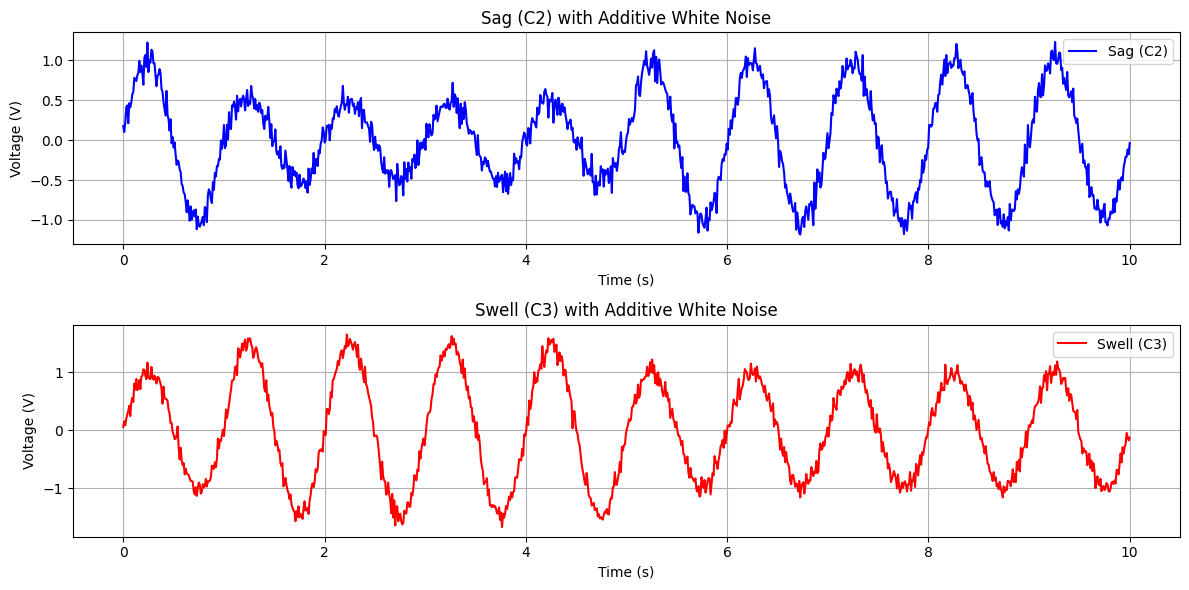

In [1]:
import numpy as np
import matplotlib.pyplot as plt

alpha_sag = 0.5   
alpha_swell = 0.5 
t1 = 1
t2 = 5
omega = 2 * np.pi  
T = 2 
time = np.linspace(0, 10, 1000)  
np.random.seed(0)  
N_sag = np.random.normal(0, 0.1, len(time))   
N_swell = np.random.normal(0, 0.1, len(time)) 

def u(t):
    return np.heaviside(t, 1)

V_sag = (1 - alpha_sag * (u(time - t1) - u(time - t2))) * np.sin(omega * time) + N_sag

V_swell = (1 + alpha_swell * (u(time - t1) - u(time - t2))) * np.sin(omega * time) + N_swell

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(time, V_sag, label='Sag (C2)', color='blue')
plt.title('Sag (C2) with Additive White Noise')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(time, V_swell, label='Swell (C3)', color='red')
plt.title('Swell (C3) with Additive White Noise')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

Without Noise

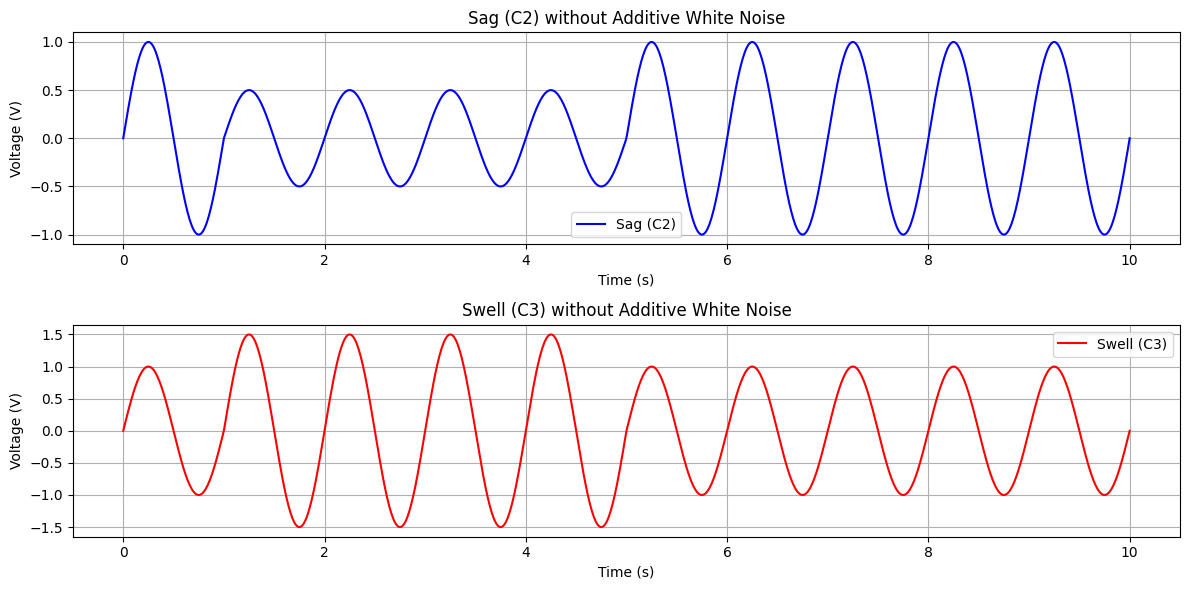

In [3]:
import numpy as np
import matplotlib.pyplot as plt

alpha_sag = 0.5   
alpha_swell = 0.5 
t1 = 1
t2 = 5
omega = 2 * np.pi  
T = 2 
time = np.linspace(0, 10, 1000)  
np.random.seed(0)  
N_sag = np.random.normal(0, 0.1, len(time))   
N_swell = np.random.normal(0, 0.1, len(time)) 

def u(t):
    return np.heaviside(t, 1)

V_sag = (1 - alpha_sag * (u(time - t1) - u(time - t2))) * np.sin(omega * time) 

V_swell = (1 + alpha_swell * (u(time - t1) - u(time - t2))) * np.sin(omega * time) 

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(time, V_sag, label='Sag (C2)', color='blue')
plt.title('Sag (C2) without Additive White Noise')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(time, V_swell, label='Swell (C3)', color='red')
plt.title('Swell (C3) without Additive White Noise')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()